In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import sys
sys.path.append('../src')
import monte_carlo as mc
import black_scholes as bs
import binomial_tree as bt
import payoff as po
from scipy.optimize import root_scalar

import pandas as pd
import yfinance as yf
import datetime as dt

** Work in progress **

In [2]:
tickers = ["SPY","AAPL","JPM","XOM"]         
start   = "1995-01-01"                
end     = None  

raw = yf.download(tickers, start=start, end=end, interval="1d",auto_adjust=True, progress=False, group_by='ticker')

close = pd.concat({t: raw[t]["Close"] for t in tickers}, axis=1)
close = close.dropna(how="all")
rets = np.log(close).diff().dropna()

In [3]:
annual_vol = rets.groupby(rets.index.year).apply(lambda x: x.std() * np.sqrt(len(x)))
annual_vol.index = pd.to_datetime(annual_vol.index.astype(str))
rolling_vol_21d = rets.rolling(window=21).std() * np.sqrt(252)
rolling_vol_63d = rets.rolling(window=63).std() * np.sqrt(252)
rolling_vol_252d = rets.rolling(window=252).std() * np.sqrt(252)

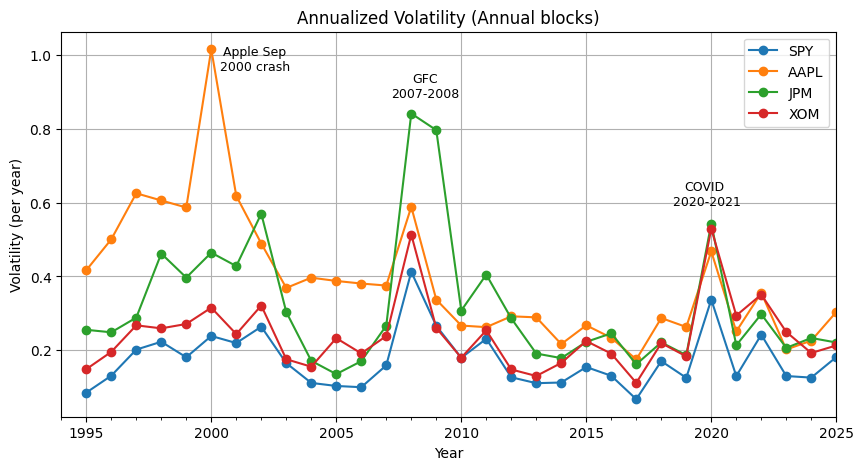

In [4]:
ax = annual_vol.plot(figsize=(10,5), marker='o', title="Annualized Volatility (Annual blocks)")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax = plt.gca()
ax.text(0.25, 0.9, "Apple Sep\n2000 crash", transform=ax.transAxes,fontsize=9, color="black",ha="center")
ax.text(0.47, 0.83, "GFC\n2007-2008", transform=ax.transAxes,fontsize=9, color="black",ha="center")
ax.text(0.83, 0.55, "COVID\n 2020-2021", transform=ax.transAxes,fontsize=9, color="black",ha="center")
plt.xlim("1994","2025") 
plt.grid(True)
plt.show()

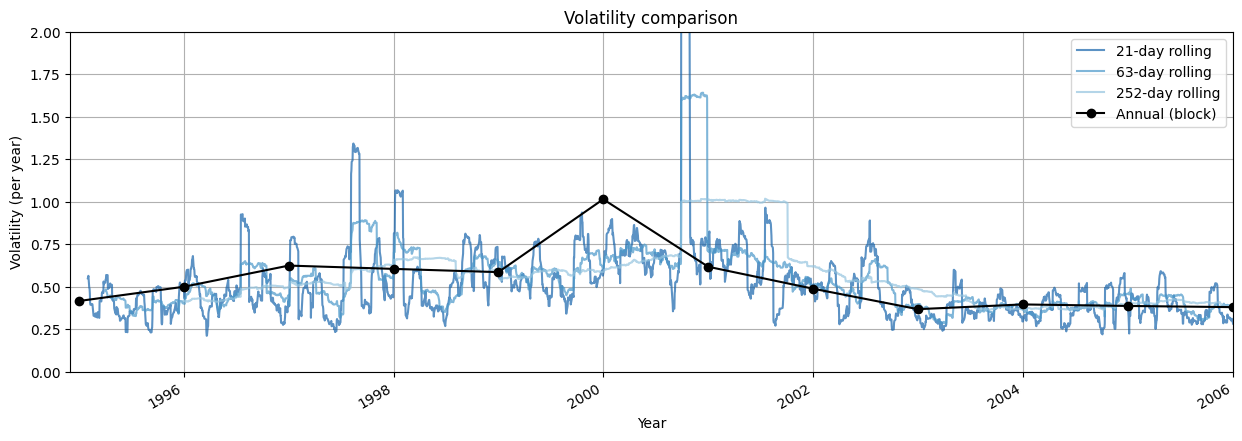

In [5]:


colors = [plt.cm.Blues(0.8),  plt.cm.Blues(0.6),plt.cm.Blues(0.4)]
fig, ax = plt.subplots(figsize=(15,5))


rolling_vol_21d["AAPL"].plot(ax=ax ,alpha=0.7,color=colors[0], label="21-day rolling")

rolling_vol_63d["AAPL"].plot(ax=ax, alpha=0.7, color=colors[1],label="63-day rolling")

rolling_vol_252d["AAPL"].plot(ax=ax, alpha=0.7,color=colors[2], label="252-day rolling")

annual_vol["AAPL"].plot(ax=ax, marker="o", color='black',label="Annual (block)")
plt.ylim(0,2) 
plt.xlim("12-1994","2006") 
ax.set_title("Volatility comparison")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True)
plt.show()

In [6]:

ewm_vol_21 = rets.ewm(halflife=21, adjust=False).std() * np.sqrt(252)
ewm_vol_63 = rets.ewm(halflife=63, adjust=False).std() * np.sqrt(252)
lam = 0.94
alpha = 1 - lam
ewm_vol_094 = rets.ewm(alpha=alpha, adjust=False).std() * np.sqrt(252)

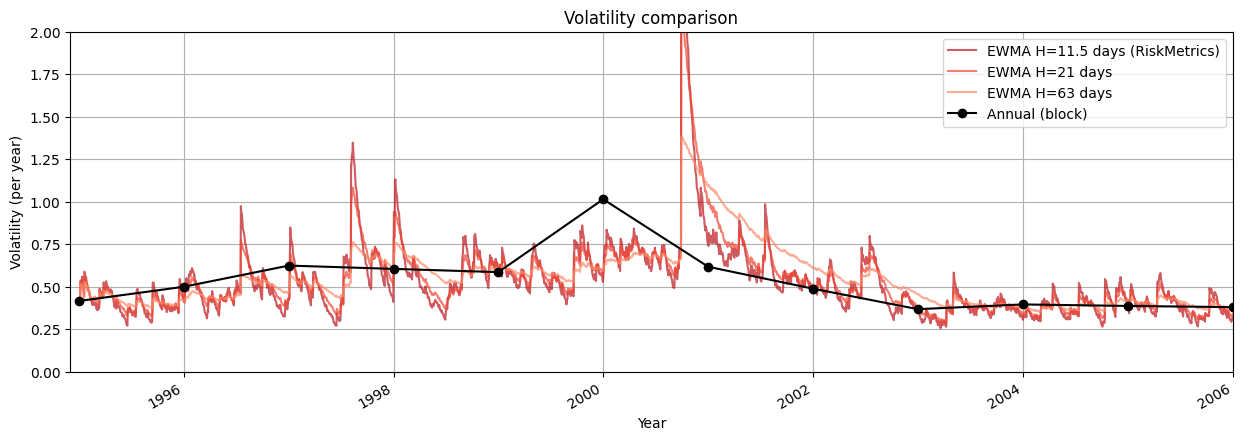

In [7]:


colors = [plt.cm.Blues(0.8),  plt.cm.Blues(0.6),plt.cm.Blues(0.4)]
colors2 = [plt.cm.Reds(0.8),  plt.cm.Reds(0.6),plt.cm.Reds(0.4)]
fig, ax = plt.subplots(figsize=(15,5))


ewm_vol_094["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[0], label="EWMA H=11.5 days (RiskMetrics)")

ewm_vol_21["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[1], label="EWMA H=21 days")

ewm_vol_63["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[2], label="EWMA H=63 days")



annual_vol["AAPL"].plot(ax=ax, marker="o", color='black',label="Annual (block)")
plt.ylim(0,2) 
plt.xlim("12-1994","2006") 
ax.set_title("Volatility comparison")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True)
plt.show()

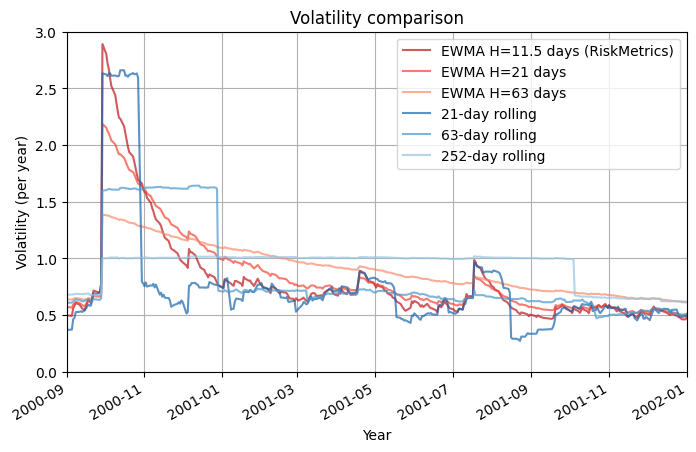

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
ewm_vol_094["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[0], label="EWMA H=11.5 days (RiskMetrics)")

ewm_vol_21["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[1], label="EWMA H=21 days")

ewm_vol_63["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[2], label="EWMA H=63 days")

rolling_vol_21d["AAPL"].plot(ax=ax ,alpha=0.7,color=colors[0], label="21-day rolling")

rolling_vol_63d["AAPL"].plot(ax=ax, alpha=0.7, color=colors[1],label="63-day rolling")

rolling_vol_252d["AAPL"].plot(ax=ax, alpha=0.7,color=colors[2], label="252-day rolling")


# annual_vol["AAPL"].plot(ax=ax, marker="o", alpha=0.2,color='black',label="Annual (block)")
plt.ylim(0,3) 
plt.xlim("09-2000","2002") 
ax.set_title("Volatility comparison")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True)
plt.show()

In [66]:
ticker = yf.Ticker("AAPL")
chain = ticker.option_chain(ticker.options[1])  # farthest expiry
calls = chain.calls


S = ticker.history(period="1d")["Close"].iloc[-1]   
K = np.array(calls.iloc[:,2])                              
expiry = pd.to_datetime(ticker.options[1])        
today = pd.Timestamp.today().normalize()
T = (expiry - today).days / 365                    
r = 0.00                                         
# price = (calls.iloc[:,4]+calls.iloc[:,5])/2;
price = calls.iloc[:,3]
impV = np.array(calls.iloc[:,10])       


In [67]:
T

0.0273972602739726

In [68]:
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250926C00110000,2025-09-08 14:24:23+00:00,110.0,129.60,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,USD
1,AAPL250926C00120000,2025-08-29 19:01:02+00:00,120.0,112.56,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,USD
2,AAPL250926C00125000,2025-09-15 14:05:40+00:00,125.0,110.45,0.0,0.0,0.0,0.0,2.0,0,0.000010,True,REGULAR,USD
3,AAPL250926C00130000,2025-09-15 14:07:49+00:00,130.0,105.59,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,USD
4,AAPL250926C00135000,2025-08-21 16:29:07+00:00,135.0,90.51,0.0,0.0,0.0,0.0,4.0,0,0.000010,True,REGULAR,USD
5,AAPL250926C00140000,2025-09-11 17:42:33+00:00,140.0,90.04,0.0,0.0,0.0,0.0,3.0,0,0.000010,True,REGULAR,USD
6,AAPL250926C00145000,2025-08-21 16:29:07+00:00,145.0,80.61,0.0,0.0,0.0,0.0,4.0,0,0.000010,True,REGULAR,USD
7,AAPL250926C00150000,2025-09-09 14:33:52+00:00,150.0,86.52,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,USD
8,AAPL250926C00155000,2025-09-15 14:05:40+00:00,155.0,80.50,0.0,0.0,0.0,0.0,2.0,0,0.000010,True,REGULAR,USD
9,AAPL250926C00160000,2025-09-15 15:24:26+00:00,160.0,76.78,0.0,0.0,0.0,0.0,2.0,0,0.000010,True,REGULAR,USD


In [47]:
res= []
for i in range(0,len(K)):
    res.append(bs.implied_vol(S, K[i] ,r, 0, T, 'call',price[i]))

res = np.array(res)

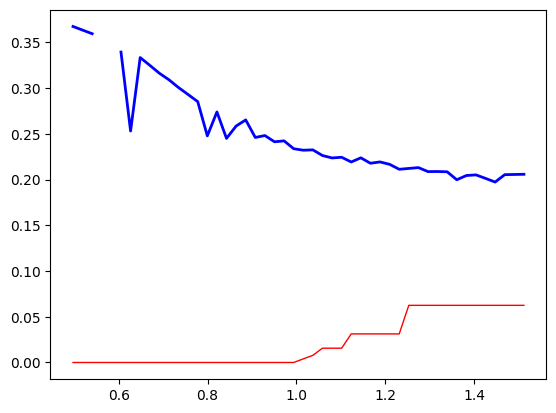

In [48]:
plt.plot(K/S , res, marker='',markersize=4,label="American T=1yr", linewidth=2,color='blue')
plt.plot(K/S , impV, marker='',markersize=4,label="European T=1yr", linewidth=1,color='red')